In [1]:
import maboss
import ginsim
import pandas as pd 
import numpy as np


from identification_patients.get_patients_sens_res import get_patients

from create_generic_models.create_generic_patients_cfgs import create_generic_patients_cfgs_bnds
from pre_process_data.pre_process_genes import create_table_rna_seq_patients, process_genes

from create_person_models.tailor_cfgs_patients_gene import personalized_patients_genes_cfgs
from create_person_models.tailor_bnd_mutations import personalized_patients_mutations_bnds

from MaBoSS_simulation.MaBoSS_phenotype_distribution import compute_phenotypes_distribution, compute_mean_patients
from pre_process_data.identify_mutations_patients import identif_mutations_kras_egfr

# # from pre_process_profiles_table_data_lung import create_genes_patients

from stats.stats_proba import compute_mannwhitneyu_test_means
from results_MaBoSS_visualization.boxplot_phenotype import create_boxplot
from results_MaBoSS_visualization.create_phenotypes_patients_table import vizualise_table_phenotype_condition
from results_MaBoSS_visualization.patients_ids_phenotype_table import create_table_patients_phenotypes
from gene_enrichment.genes_signature import compute_genes_mean_signature


In [2]:
import os
print(os.getcwd())


/Users/romane/repos/icr/Attractor-Resistance


Step 0: Import data 

In [3]:
# Import Data

annotations_models = pd.read_csv('data/model_list_20250407.csv')
mutations_data = pd.read_csv('data/mutations_all_20250318.csv')
drug_data = pd.read_csv('data/drug_sensitivity.csv')

montagud_data = (
    pd.read_csv('data/Montagud_inter_nodes_data.csv', header=1)
    .loc[:, ['Target node', 'Interaction type', 'Source']])
rna_seq_data = pd.read_csv('data/rnaseq_merged/rnaseq_merged_20250117.csv')


Step 1: Pre-process data- Montagud nodes, rna-seq (filtered with patients IDs and Montagud nodes)

In [4]:
# Pre-process Montagud nodes

# Keep only the nodes of montagud not specific to Prostate 
montagud_nodes = list(set(montagud_data['Target node'].tolist() + montagud_data['Source'].tolist()))
montagud_nodes = [node for node in montagud_nodes if node != '0/1']
montagud_nodes = [node.upper() for node in montagud_nodes if isinstance(node, str)]
montagud_nodes.append('KRAS')
to_remove = ['RAS', 'FUSED_EVENT', 'NKX3_1', 'SPOP', 'AR_ERG']

montagud_nodes = [node for node in montagud_nodes if node not in to_remove]
montagud_nodes = list(set(montagud_nodes))

In [5]:
# chose folder where we want all the personalized boolean models and associated results saved 
folder_pers_models='models/personalized_boolean_large_groups'
folder_result = 'results'
# Output directories
output_dir_resistant = f'{folder_pers_models}/resistant_patient/generic_models'
output_dir_sec_resistant = f'{folder_pers_models}/resistant_patient/personalized_boolean_modified'
output_dir_sensitive = f'{folder_pers_models}/sensitive_patient/generic_models'
output_dir_sec_sensitive = f'{folder_pers_models}/sensitive_patient/personalized_boolean_modified'
bnd_dir_res = f'{folder_pers_models}/resistant_patient/personalized_boolean_modified/models_gene_expression'
bnd_dir_sens = f'{folder_pers_models}/sensitive_patient/personalized_boolean_modified/models_gene_expression'



In [6]:
tissue_remove = 'Haematopoietic and Lymphoid'
# tissue_interest = 'Lung'

Step 1: Check what drug is the best to keep (the one with most resistant and sensitive)

In [7]:
# results = {}
# drug_interests = drug_data['DRUG_NAME'].unique().tolist()

# for drug in drug_interests:
#     top_resistant_ids, top_sensitive_ids, drug_data_filtered = get_patients(500, drug_data, annotations_models, drug, tissue_remove)
#     patients_ids = top_resistant_ids + top_sensitive_ids

#     drug_tissue_filtered = drug_data_filtered[drug_data_filtered['SANGER_MODEL_ID'].isin(patients_ids)]    
#     results[drug] = {
#          "name": drug,
#          "<-1.5": float((drug_tissue_filtered['Z_SCORE'] < -1.5).sum()),
#          ">1.5": float((drug_tissue_filtered['Z_SCORE'] > 1.5).sum()),
#          "mean": float(drug_tissue_filtered['Z_SCORE'].mean()),
#          "std": float(drug_tissue_filtered['Z_SCORE'].std()),
#          "abs_zscore": float(drug_tissue_filtered['Z_SCORE'].abs().mean()),
#      }

# pd_results = pd.DataFrame(results.values())
# pd_results.to_csv(f'{folder_result}/drug_analysis.csv', index=False)




Step 2: Select cancer and drug of interest (tissue_interest, drug_interest)
Get the 100 most sensitive patient
Pre-process data


In [8]:
# Get patients IDs

# changed the drug name to Pictilisib !!!!

# top_resistant_ids, top_sensitive_ids= get_patients(drug_data, annotations_models, drug_interest, tissue_interest)
drug_interest = 'Pictilisib' #'Avagacestat' AZD8931
top_resistant_ids, top_sensitive_ids, drug_tissue_data= get_patients(50, drug_data, annotations_models, drug_interest, tissue_remove)
patients_ids = top_sensitive_ids + top_resistant_ids



sensitive
    SANGER_MODEL_ID   Z_SCORE
117       SIDM00994 -0.822723
71        SIDM00502 -0.803875
74        SIDM00553 -0.784600
133       SIDM01023 -0.783271
21        SIDM00362 -0.775963
resistant
    SANGER_MODEL_ID   Z_SCORE
93        SIDM00808  0.516219
48        SIDM00433  0.500754
106       SIDM00946  0.472888
119       SIDM01004  0.466861
102       SIDM00896  0.459014


/Users/romane/repos/icr/Attractor-Resistance/identification_patients/get_patients_sens_res.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  annotations_models_filtered.rename(columns={"model_id": "SANGER_MODEL_ID"}, inplace=True)


In [9]:
# Pre-process RNA seq data (keep only montagud_nodes and patients ids) and create table for high and low expression
rna_seq_data_filtered = process_genes(patients_ids, montagud_nodes, rna_seq_data)
table_rna_seq_patients = create_table_rna_seq_patients(rna_seq_data_filtered)

/Users/romane/repos/icr/Attractor-Resistance/pre_process_data/pre_process_genes.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rna_seq_data.rename(columns={'gene_symbol': 'gene_name'}, inplace=True)


In [10]:
print(rna_seq_data_filtered.head())

        model_id gene_symbol  rsem_tpm   z_score gene_expression_level
25269  SIDM00949         BAD    5.2683  0.001129                normal
25299  SIDM01023         BAD    5.2854  0.027320                normal
25301  SIDM00327         BAD    5.4919  0.343601                normal
25317  SIDM00331         BAD    5.3420  0.114010                normal
25382  SIDM00447         BAD    5.6988  0.660494                normal


Step 3: Create generic boolean networks with the sensitive and resistant ID names


In [11]:
folder_generic_models_cfg = 'models/generic_models/Adeno_lung_Cancer.cfg'
folder_generic_models_bnd = 'models/generic_models/Adeno_lung_Cancer.bnd'
create_generic_patients_cfgs_bnds(folder_generic_models_cfg, folder_generic_models_bnd, folder_pers_models, top_resistant_ids, top_sensitive_ids, drug_interest)


All .cfg and .bnd files created for sensitive and resistant patients.


Step 4: Personalize the cfg files with genes/ proteins


TO DO!!!!!!!!!!!:
NOTHING HAS CHANGED 

In [12]:
# check how many genes info we have the selected patients
# print(rna_seq_data.head())

rna_seq_data = rna_seq_data[rna_seq_data['model_id'].isin(patients_ids)]
rna_seq_data = rna_seq_data[rna_seq_data['gene_symbol'].isin(montagud_nodes)]
print(rna_seq_data)
print(len(rna_seq_data['model_id'].unique().tolist()))

          model_name   model_id gene_symbol  ensembl_gene_id    gene_id  \
25269            DEL  SIDM00949         BAD  ENSG00000002330  SIDG02081   
25299     MONO-MAC-6  SIDM01023         BAD  ENSG00000002330  SIDG02081   
25301          L-428  SIDM00327         BAD  ENSG00000002330  SIDG02081   
25317     MHH-CALL-2  SIDM00331         BAD  ENSG00000002330  SIDG02081   
25382            REH  SIDM00447         BAD  ENSG00000002330  SIDG02081   
...              ...        ...         ...              ...        ...   
61590120     LAMA-84  SIDM00346       MED12  ENSG00000184634  SIDG17493   
61590440     LAMA-84  SIDM00346       PTCH1  ENSG00000185920  SIDG26185   
61591434     LAMA-84  SIDM00346       NCOR2  ENSG00000196498  SIDG21495   
61591503     LAMA-84  SIDM00346         NF1  ENSG00000196712  SIDG21750   
61593504     LAMA-84  SIDM00346        DAXX  ENSG00000204209  SIDG06056   

          htseq_read_count  rsem_expected_count  rsem_fpkm  rsem_tpm  \
25269                  NaN 

In [14]:
drug_interest = 'Pictilisib'
# only three modif for resistant
personalized_patients_genes_cfgs(rna_seq_data, montagud_data, output_dir_resistant, output_dir_sec_resistant, patients_ids, table_rna_seq_patients, drug_interest)
personalized_patients_genes_cfgs(rna_seq_data_filtered, montagud_data, output_dir_sensitive, output_dir_sec_sensitive, patients_ids, table_rna_seq_patients, drug_interest)

Modified and saved: models/personalized_boolean_large_groups/resistant_patient/personalized_boolean_modified/models_gene_expression/SIDM01102_Pictilisib.cfg
Modified and saved: models/personalized_boolean_large_groups/resistant_patient/personalized_boolean_modified/models_gene_expression/SIDM00495_Pictilisib.cfg
Modified and saved: models/personalized_boolean_large_groups/resistant_patient/personalized_boolean_modified/models_gene_expression/SIDM00423_Pictilisib.bnd
Modified and saved: models/personalized_boolean_large_groups/resistant_patient/personalized_boolean_modified/models_gene_expression/SIDM01092_Pictilisib.cfg
Modified and saved: models/personalized_boolean_large_groups/resistant_patient/personalized_boolean_modified/models_gene_expression/SIDM00785_Pictilisib.bnd
Modified and saved: models/personalized_boolean_large_groups/resistant_patient/personalized_boolean_modified/models_gene_expression/SIDM00327_Pictilisib.cfg
Modified and saved: models/personalized_boolean_large_grou

Step 5: Identification of which patients id have KRAS or EGFR mutation
personalize the bnd files with the mutations common to Lung (KRAS/ EGFR):

In [ ]:
personalized_patients_mutations_bnds(mutations_data,patients_ids,bnd_dir_res, drug_interest)
personalized_patients_mutations_bnds(mutations_data,patients_ids,bnd_dir_sens, drug_interest)

Step 6: compute the phenotype distribution 

In [16]:
dic_patient_resistant =f'{folder_pers_models}/resistant_patient/personalized_boolean_modified/models_gene_expression'
dic_patient_sensitive =f'{folder_pers_models}/sensitive_patient/personalized_boolean_modified/models_gene_expression'
inputs_list = ['EGF', 'FGF', 'TGFb', 'Nutrients', 'Hypoxia', 'Acidosis', 'Androgen', 'TNFalpha', 'Carcinogen']


patient_res_data_dict = compute_phenotypes_distribution(folder_result, dic_patient_resistant, inputs_list, 'resistant', drug_interest)
patient_sens_data_dict = compute_phenotypes_distribution(folder_result, dic_patient_sensitive, inputs_list, 'sensitive', drug_interest)
patients_res_df_mean, patients_res_df_std, stats_results_data_res_df = compute_mean_patients(patient_res_data_dict)
patients_sens_df_mean, patients_sens_df_std, stats_results_data_sens_df = compute_mean_patients(patient_sens_data_dict)



patients_res_df_mean.to_csv(f'{folder_result}/resistant_results/only_gene_expression/single_input_on/patients_resistant_df_mean_{drug_interest}.csv', index=True)
patients_res_df_std.to_csv(f'{folder_result}/resistant_results/only_gene_expression/single_input_on/patients_resistant_df_std_{drug_interest}.csv', index=True)
stats_results_data_res_df.to_csv(f'{folder_result}/resistant_results/only_gene_expression/single_input_on/patients_resistant_values_stats_{drug_interest}.csv', index=True)
stats_results_data_sens_df.to_csv(f'{folder_result}/sensitive_results/only_gene_expression/single_input_on/patients_sensitive_values_stats_{drug_interest}.csv', index=True)
patients_sens_df_mean.to_csv(f'{folder_result}/sensitive_results/only_gene_expression/single_input_on/patients_sensitive_df_mean_{drug_interest}.csv', index=True)
patients_sens_df_std.to_csv(f'{folder_result}/sensitive_results/only_gene_expression/single_input_on/patients_sensitive_df_std_{drug_interest}.csv', index=True)




--- Results for patient: SIDM01102_Pictilisib ---
                  <nil>  Apoptosis  Proliferation  Metastasis
EGF_ON         0.925200   0.000000       0.000000    0.000000
FGF_ON         0.678045   0.051309       0.233970    0.014827
TGFb_ON        0.015659   0.732393       0.000200    0.247948
Nutrients_ON   0.478545   0.000000       0.491528    0.006958
Hypoxia_ON     0.974793   0.000000       0.000000    0.025207
Acidosis_ON    0.920082   0.000000       0.047403    0.017814
Androgen_ON    0.922800   0.000000       0.000000    0.000000
TNFalpha_ON    0.506155   0.000000       0.022013    0.453345
Carcinogen_ON  0.229762   0.676674       0.047134    0.010880

--- Results for patient: SIDM00495_Pictilisib ---
                  <nil>  Apoptosis  Proliferation  Metastasis
EGF_ON         0.928000   0.000000       0.000000    0.000000
FGF_ON         0.513449   0.370781       0.074682    0.011703
TGFb_ON        0.000000   1.000000       0.000000    0.000000
Nutrients_ON   0.803176   0.00

Step 7: Compute stats test between two mean datasets

In [17]:
patient_res_stats_values = pd.read_csv(f'{folder_result}/resistant_results/only_gene_expression/single_input_on/patients_resistant_values_stats_{drug_interest}.csv')
patient_sens_stats_values = pd.read_csv(f'{folder_result}/sensitive_results/only_gene_expression/single_input_on/patients_sensitive_values_stats_{drug_interest}.csv')
compute_mannwhitneyu_test_means(folder_result,patient_res_stats_values, patient_sens_stats_values, drug_interest)

Step 8: Vizualise the boxplot of phenotype distribution output

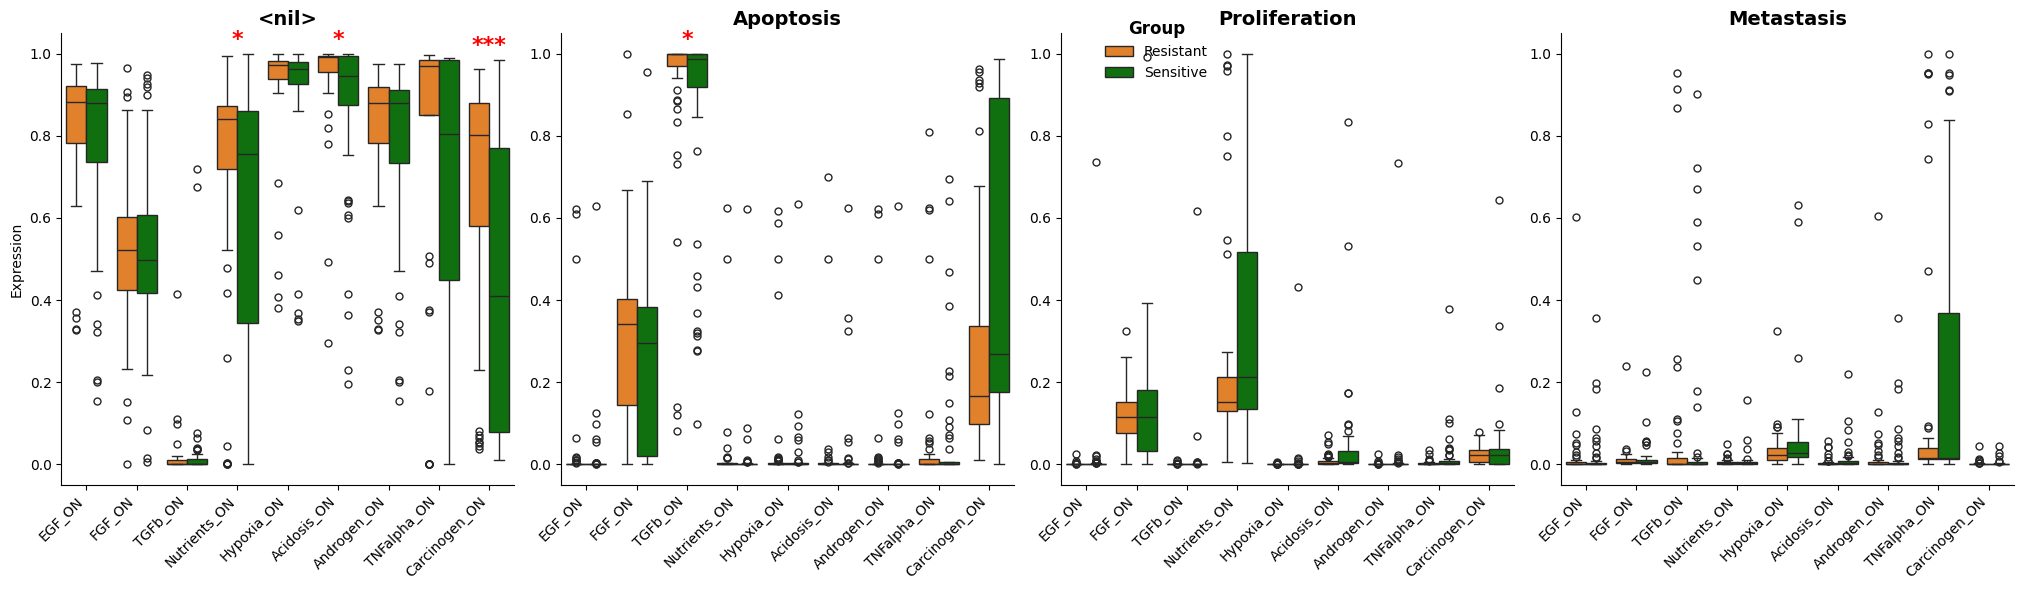

In [18]:
patient_res_values = pd.read_csv(f'{folder_result}/resistant_results/only_gene_expression/single_input_on/patients_resistant_values_stats_{drug_interest}.csv')
patient_sens_values = pd.read_csv(f'{folder_result}/sensitive_results/only_gene_expression/single_input_on/patients_sensitive_values_stats_{drug_interest}.csv')
data_greater_side = pd.read_csv(f'{folder_result}/sensitive_resistant_results/p_values_df_mannwhitneyu_greater_sign_{drug_interest}.csv')
create_boxplot(folder_result, patient_res_values, patient_sens_values, data_greater_side)

Step 9: create table of patients with conditions- phenotype

In [19]:
dir_res_data = f'{folder_result}/resistant_results/only_gene_expression/single_input_on/phenotype_distribution_patients'
dir_sens_data = f'{folder_result}/sensitive_results/only_gene_expression/single_input_on/phenotype_distribution_patients'
patients_phenot_table = create_table_patients_phenotypes(folder_result, dir_res_data, dir_sens_data)

Loaded data for SIDM00700_AZD8931_phenotypes, shape: (9, 4)
Loaded data for SIDM00454_AZD8931_phenotypes, shape: (9, 4)
Loaded data for SIDM00327_Pictilisib_phenotypes, shape: (9, 4)
Loaded data for SIDM01181_AZD8931_phenotypes, shape: (9, 4)
Loaded data for SIDM00331_AZD8931_phenotypes, shape: (9, 4)
Loaded data for SIDM01104_AZD8931_phenotypes, shape: (9, 4)
Loaded data for SIDM00826_AZD8931_phenotypes, shape: (9, 4)
Loaded data for SIDM00632_Pictilisib_phenotypes, shape: (9, 4)
Loaded data for SIDM00648_AZD8931_phenotypes, shape: (9, 4)
Loaded data for SIDM00410_AZD8931_phenotypes, shape: (9, 4)
Loaded data for SIDM00287_Pictilisib_phenotypes, shape: (9, 4)
Loaded data for SIDM00859_AZD8931_phenotypes, shape: (9, 4)
Loaded data for SIDM00363_Pictilisib_phenotypes, shape: (9, 4)
Loaded data for SIDM00446_Pictilisib_phenotypes, shape: (9, 4)
Loaded data for SIDM00492_AZD8931_phenotypes, shape: (9, 4)
Loaded data for SIDM00230_AZD8931_phenotypes, shape: (9, 4)
Loaded data for SIDM00194

Step 10: Create heatmap figure 

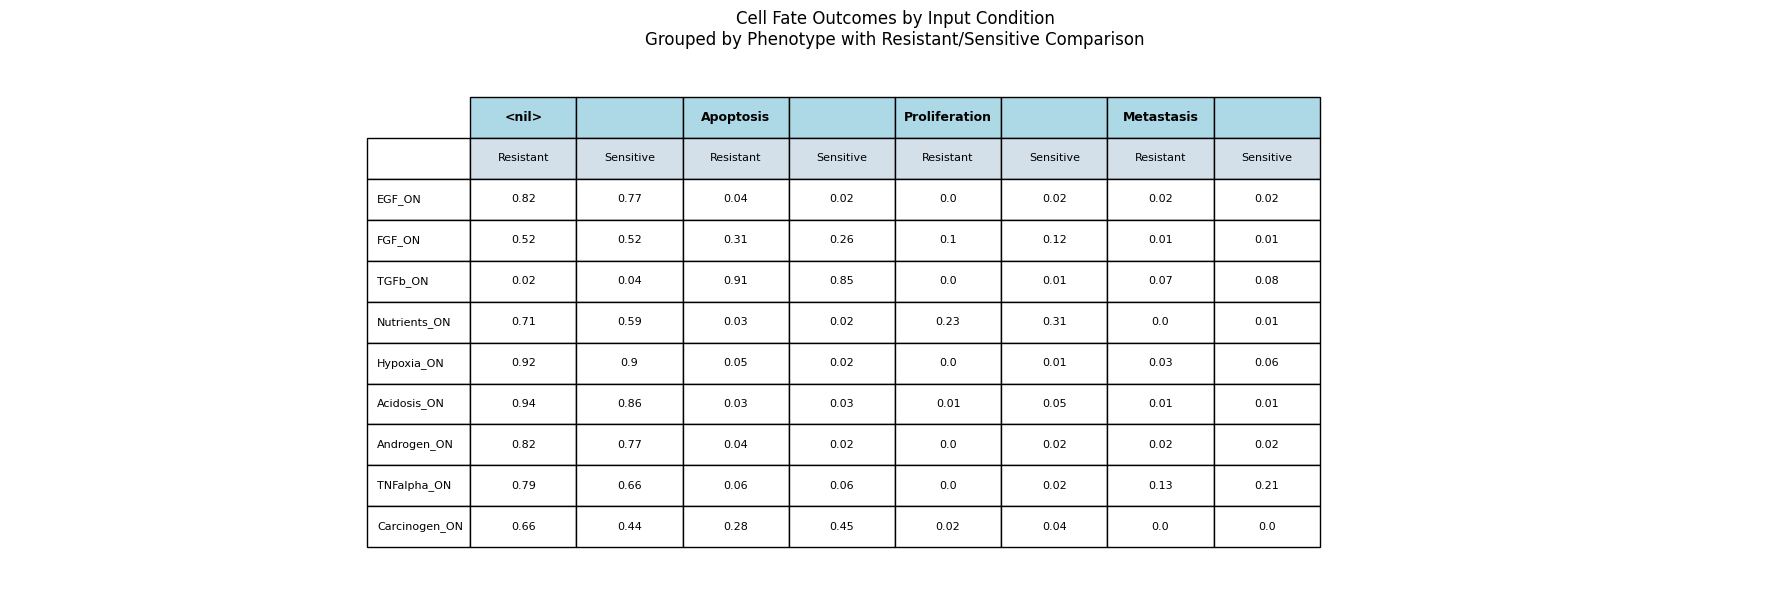

In [20]:
patient_resistant_mean = pd.read_csv(f'{folder_result}/resistant_results/only_gene_expression/single_input_on/patients_resistant_df_mean_{drug_interest}.csv')
patient_sensitive_mean = pd.read_csv(f'{folder_result}/sensitive_results/only_gene_expression/single_input_on/patients_sensitive_df_mean_{drug_interest}.csv')
vizualise_table_phenotype_condition(folder_result, patient_resistant_mean, patient_sensitive_mean)

Step 11: Identify genes differently expressed in the patients with high 

In [21]:
patients_phenot_table = pd.read_csv(f'{folder_result}/sensitive_resistant_results/patients_phenot_table.csv')
genes_stats_results_metast_TGFb,  len_resistant_group_id_metast_TGFb, len_sensitive_group_ids_metast_TGFb = compute_genes_mean_signature(rna_seq_data_filtered, folder_result, 'Metastasis', 'TGFb', patients_phenot_table, top_resistant_ids, top_sensitive_ids)
genes_stats_results_prolif_egf,  len_resistant_group_ids_prolif_egf, len_sensitive_group_ids_prolif_egf = compute_genes_mean_signature(rna_seq_data_filtered, folder_result, 'Proliferation', 'EGF', patients_phenot_table, top_resistant_ids, top_sensitive_ids)

/Users/romane/repos/icr/Attractor-Resistance/gene_enrichment/genes_signature.py:74: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  _, p_normal_group_1 = stats.shapiro(group_resistant_phenotype)
/Users/romane/repos/icr/Attractor-Resistance/gene_enrichment/genes_signature.py:82: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  u_stat, p_value = stats.mannwhitneyu(group_resistant_phenotype, group_sensitive)
/Users/romane/repos/icr/Attractor-Resistance/gene_enrichment/genes_signature.py:74: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  _, p_normal_group_1 = stats.shapiro(group_resistant_phenotype)
/Users/romane/repos/icr/Attractor-Resistance/gene_enrichment/genes_signature.py:82: SmallSampleWarning:

In [22]:
print(len_resistant_group_id_metast_TGFb)
print(len_sensitive_group_ids_metast_TGFb)

print(len_resistant_group_ids_prolif_egf)
print(len_sensitive_group_ids_prolif_egf)

18
57
0
57


Step 11: check there is not correlation between phenotype distribution and cancer type 


In [24]:
# patients_phenot_table['SANGER_MODEL_ID'] = patients_phenot_table['Unnamed: 0'].str.split('_').str[0]
# conditions = [
#     patients_phenot_table['SANGER_MODEL_ID'].isin(top_resistant_ids),
#     patients_phenot_table['SANGER_MODEL_ID'].isin(top_sensitive_ids)
#     ]
# choices = ['Resistant', 'Sensitive']
# patients_phenot_table.loc[:,'Drug status'] = np.select(conditions, choices, default = '')



# ids_tissue_data = drug_tissue_data[['SANGER_MODEL_ID', 'tissue']]
# ids_tissue_data = ids_tissue_data.drop_duplicates(subset='SANGER_MODEL_ID')


# # merge tissues and model id 
# patients_phenot_table = pd.merge(patients_phenot_table, ids_tissue_data, on = 'SANGER_MODEL_ID')



# # look the number of each cancer for the condition-phenotype of interest
# condition = 'TGFb'
# phenotype = 'Metastasis'


# # resistant group changes according to what is the condition and the phenotype
# # group_proliferation_resistant: group with high phenotype 

# group_phenotype_resistant = patients_phenot_table[
#     (patients_phenot_table['Drug status'] == 'Resistant') & 
#     (patients_phenot_table[f'{condition}_ON_{phenotype}'] >= 0.1)
# ]

# # print(group_phenotype_resistant['tissue'].value_counts()) # EGF- proliferation: 4 lung, 1 breast, 1 haematopoetic
# #                                                           # TGFb- Metastasis: 21 haemato, 2 skin, 2 breast, 1 lung, 1 large intestine, 1 endom, 1 liver


In [31]:
inputs = ['EGF', 'FGF', 'Nutrients', 'Androgen']
results = []
output_dir = f'{folder_result}/sensitive_results/only_gene_expression/all_inputs_on/phenotype_distribution_patients'
os.makedirs(output_dir, exist_ok=True)
cfg_files = [f for f in os.listdir(dic_patient_sensitive) if f.endswith(f"{drug_interest}.cfg")]
for cfg_file in cfg_files:
    cfg_path = os.path.join(dic_patient_sensitive, cfg_file)
    base_name = os.path.splitext(cfg_file)[0]
    bnd_path = os.path.join(dic_patient_sensitive, base_name + ".bnd")
    model = maboss.load(bnd_path, cfg_path)
    for input_node in inputs:
        model.network.set_istate(input_node, [0.0, 1.0])  # ON
    result = model.run()
    probtraj = result.get_last_states_probtraj()
    probtraj["Patient_ID"] = base_name
    results.append(probtraj)
combined_df = pd.concat(results, ignore_index=True)
combined_csv_path = os.path.join(output_dir, "all_patients_all_inputs_on_probtraj.csv")
combined_df.to_csv(combined_csv_path, index=False)
print(f"Saved combined results to: {combined_csv_path}")


Saved combined results to: results/sensitive_results/only_gene_expression/all_inputs_on/phenotype_distribution_patients/all_patients_all_inputs_on_probtraj.csv


In [36]:
results_resistant = pd.read_csv('results/resistant_results/only_gene_expression/all_inputs_on/phenotype_distribution_patients/all_patients_all_inputs_on_probtraj.csv')
results_sensitive = pd.read_csv('results/sensitive_results/only_gene_expression/all_inputs_on/phenotype_distribution_patients/all_patients_all_inputs_on_probtraj.csv')



print('Apoptosis')

resistant_apopto_mean = results_resistant['Apoptosis'].mean()
print(resistant_apopto_mean)

sensitive_apopto_mean = results_sensitive['Apoptosis'].mean()
print(sensitive_apopto_mean)



print('Proliferation')
resistant_prolif_mean = results_resistant['Proliferation'].mean()
print(resistant_prolif_mean)

sensitive_prolif_mean = results_sensitive['Proliferation'].mean()
print(sensitive_prolif_mean)



print('Metastasis')
resistant_metas_mean = results_resistant['Metastasis'].mean()
print(resistant_metas_mean)

sensitive_metas_mean = results_sensitive['Metastasis'].mean()
print(sensitive_metas_mean)


Apoptosis
0.6856494489795919
0.6438666200000001
Proliferation
0.05117761224489795
0.054546080000000004
Metastasis
0.1475944081632653
0.15153471999999998


In [ ]:
# TO DO: later- changes EGF and TGF initial states according to expression
